In [173]:
import random
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    log_loss,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [174]:
SEED = 1

In [175]:
random.seed(SEED)
np.random.seed(SEED)

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/wojtek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wojtek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [176]:
resumes = pd.read_csv('../data/resumes.csv')
resumes.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# Pre-processing

In [177]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
label_encoder = LabelEncoder()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

resumes['Resume_str'] = resumes['Resume_str'].apply(clean_text)

X = resumes['Resume_str']
y = label_encoder.fit_transform(resumes['Category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

vectorizer = TfidfVectorizer(ngram_range=(1,5), stop_words=stopwords.words('english'), max_features=10000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Training

In [178]:
best_model = None
best_params = None
best_test_accuracy = 0
best_train_losses = []
best_test_losses = []
best_train_accuracies = []
best_test_accuracies = []

param_grid = {
    'objective': ['multi:softprob'],
    'num_class': [len(label_encoder.classes_)],
    'eval_metric': ['mlogloss'],
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'lambda': [1, 5, 10],
    'alpha': [0, 1, 5],
    'num_boost_round': [50, 100, 200]
}

random_combinations = list(ParameterSampler(param_grid, n_iter=10, random_state=SEED))

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

total_combinations = len(random_combinations)
completed_combinations = 0

print(f"Starting grid search over {total_combinations} random combinations...")

for params in random_combinations:
    num_boost_round = params.pop('num_boost_round')

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    class RecordMetricsCallback(xgb.callback.TrainingCallback):
        def after_iteration(self, model, epoch, evals_log):
            y_train_pred = model.predict(dtrain)
            y_test_pred = model.predict(dtest)

            train_loss = log_loss(y_train, y_train_pred)
            test_loss = log_loss(y_test, y_test_pred)
            train_losses.append(train_loss)
            test_losses.append(test_loss)

            train_accuracy = accuracy_score(y_train, np.argmax(y_train_pred, axis=1))
            test_accuracy = accuracy_score(y_test, np.argmax(y_test_pred, axis=1))
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)

            return False

    xgb_classifier = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtest, 'test')],
        callbacks=[RecordMetricsCallback()],
    )

    if test_accuracies[-1] > best_test_accuracy:
        best_model = xgb_classifier
        best_params = params
        best_test_accuracy = test_accuracies[-1]
        best_train_losses = train_losses
        best_test_losses = test_losses
        best_train_accuracies = train_accuracies
        best_test_accuracies = test_accuracies

    completed_combinations += 1
    print(f"Completed {completed_combinations}/{total_combinations} combinations...")
    print(f"Current Best Test Accuracy: {best_test_accuracy:.4f}")

print("\nGrid Search Completed.")
print("Best Parameters:", best_params)
print("Best Test Accuracy:", best_test_accuracy)

Starting grid search over 2 random combinations...
[0]	test-mlogloss:2.96884
[1]	test-mlogloss:2.79839
[2]	test-mlogloss:2.65440
[3]	test-mlogloss:2.54148
[4]	test-mlogloss:2.44212
[5]	test-mlogloss:2.35764
[6]	test-mlogloss:2.28450
[7]	test-mlogloss:2.21237
[8]	test-mlogloss:2.14447
[9]	test-mlogloss:2.07964
[10]	test-mlogloss:2.02154
[11]	test-mlogloss:1.96704
[12]	test-mlogloss:1.91764
[13]	test-mlogloss:1.87629
[14]	test-mlogloss:1.83428
[15]	test-mlogloss:1.79312
[16]	test-mlogloss:1.75649
[17]	test-mlogloss:1.72423
[18]	test-mlogloss:1.68907
[19]	test-mlogloss:1.65811
[20]	test-mlogloss:1.62512
[21]	test-mlogloss:1.59584
[22]	test-mlogloss:1.56713
[23]	test-mlogloss:1.54223
[24]	test-mlogloss:1.51587
[25]	test-mlogloss:1.49304
[26]	test-mlogloss:1.46917
[27]	test-mlogloss:1.44938
[28]	test-mlogloss:1.43004
[29]	test-mlogloss:1.41034
[30]	test-mlogloss:1.38951
[31]	test-mlogloss:1.37183
[32]	test-mlogloss:1.35430
[33]	test-mlogloss:1.33871
[34]	test-mlogloss:1.32231
[35]	test-mlog

# Accuracy

In [179]:
y_pred_probs = best_model.predict(xgb.DMatrix(X_test))
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.7646
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        24
           1       0.79      0.79      0.79        28
           2       0.80      0.33      0.47        12
           3       0.40      0.38      0.39        16
           4       0.72      0.62      0.67        21
           5       0.50      0.25      0.33         8
           6       0.88      0.82      0.85        17
           7       0.64      0.70      0.67        23
           8       0.00      0.00      0.00         4
           9       0.90      0.81      0.85        32
          10       0.88      0.92      0.90        25
          11       0.79      0.96      0.86        23
          12       0.74      0.77      0.76        22
          13       0.86      0.90      0.88        20
          14       0.74      0.69      0.71        29
          15       0.84      0.88      0.86        24
          16       0.73      0.79      0.

/home/wojtek/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wojtek/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wojtek/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Loss per epoch

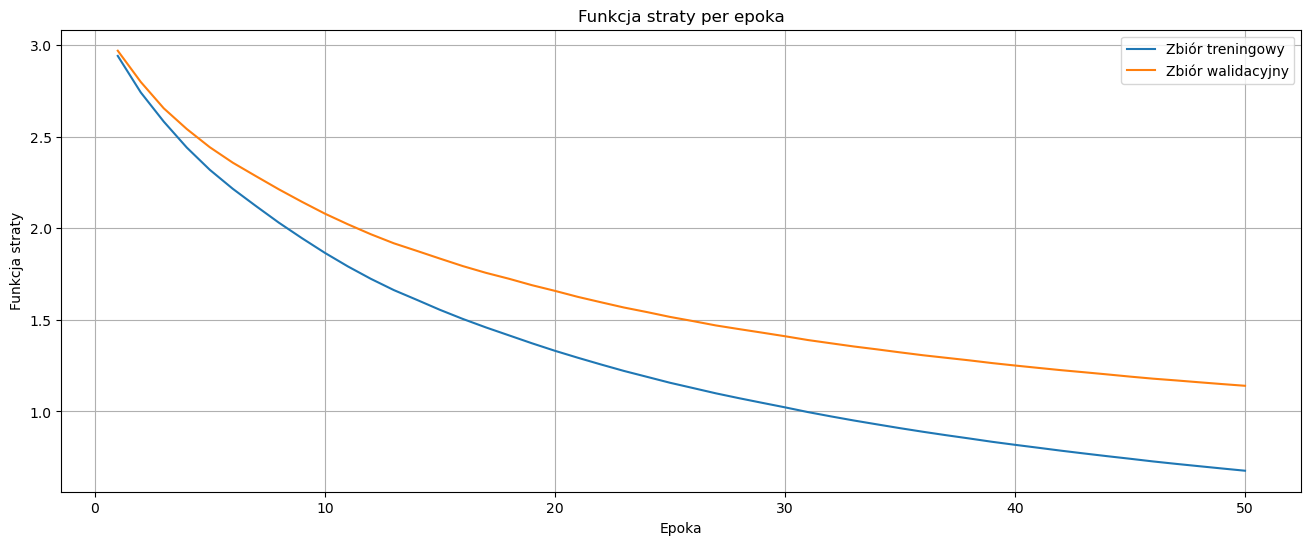

In [182]:
plt.figure(figsize=(16, 6))
plt.plot(np.arange(1, len(best_train_losses) + 1), best_train_losses, label='Zbiór treningowy')
plt.plot(np.arange(1, len(best_test_losses) + 1), best_test_losses, label='Zbiór walidacyjny')
plt.xticks(np.arange(0, len(best_test_losses) + 1, step=10))
plt.title('Funkcja straty per epoka')
plt.xlabel('Epoka')
plt.ylabel('Funkcja straty')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy per epoch

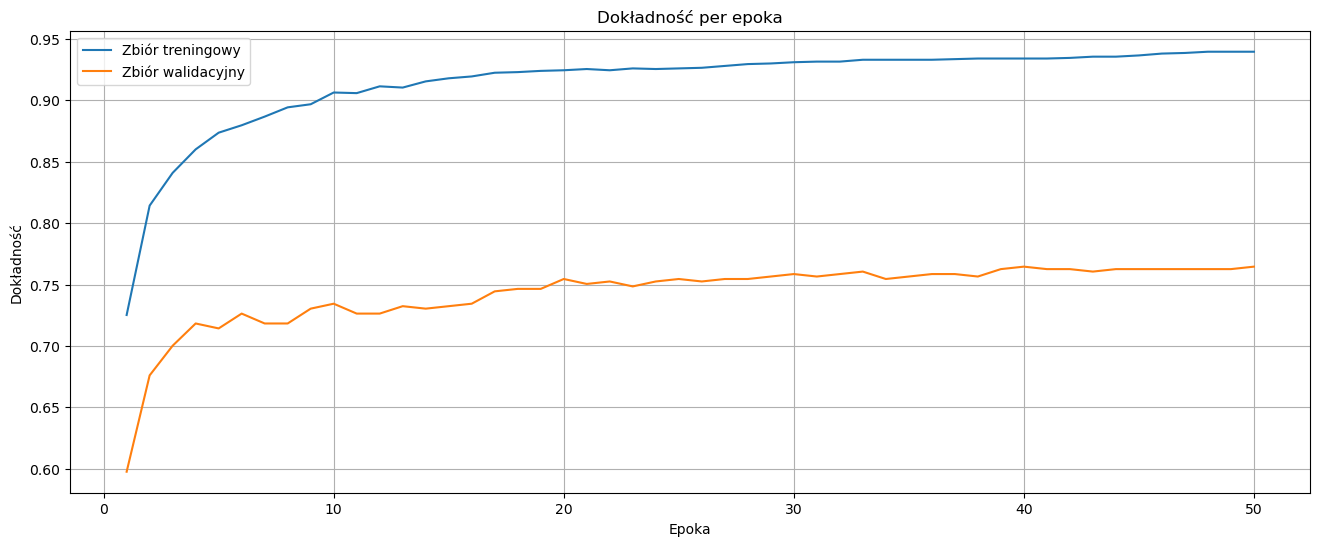

In [183]:
plt.figure(figsize=(16, 6))
plt.plot(np.arange(1, len(best_train_accuracies) + 1), best_train_accuracies, label='Zbiór treningowy')
plt.plot(np.arange(1, len(best_test_accuracies) + 1), best_test_accuracies, label='Zbiór walidacyjny')
plt.xticks(np.arange(0, len(best_test_losses) + 1, step=10))
plt.title('Dokładność per epoka')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix

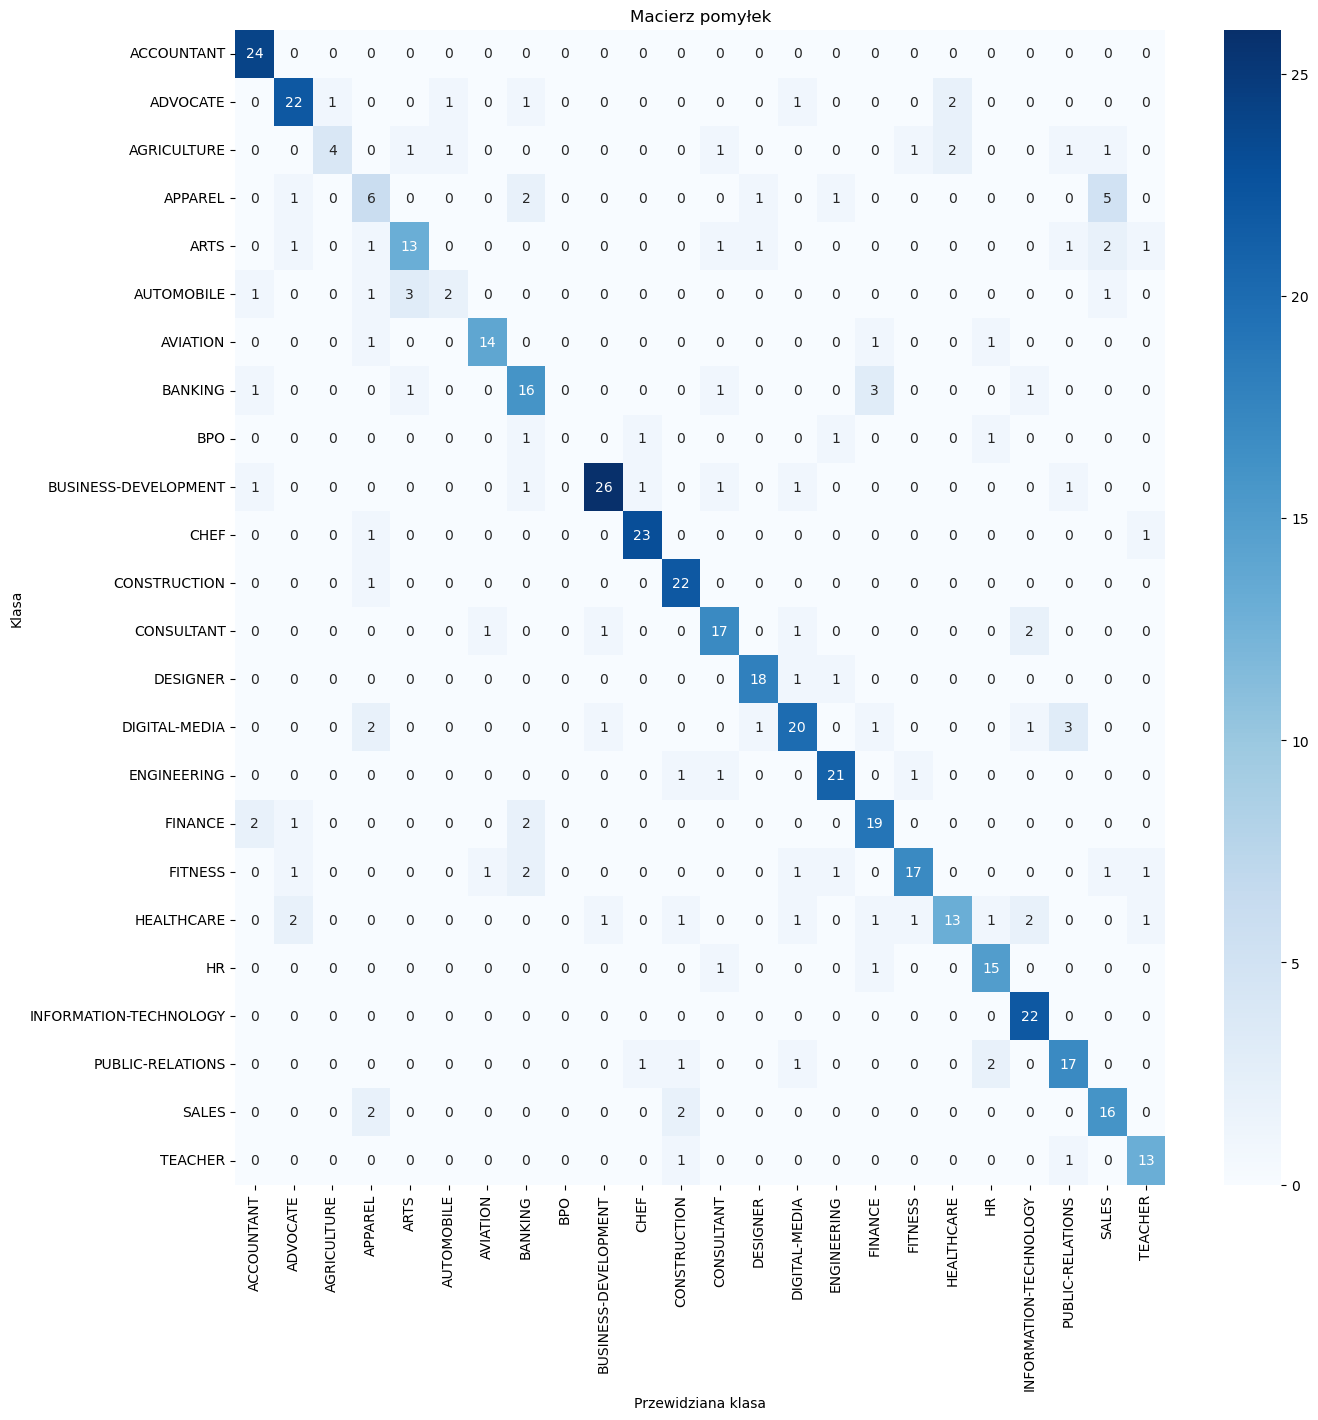

In [184]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Klasa')
plt.show()

# Accuracy per class

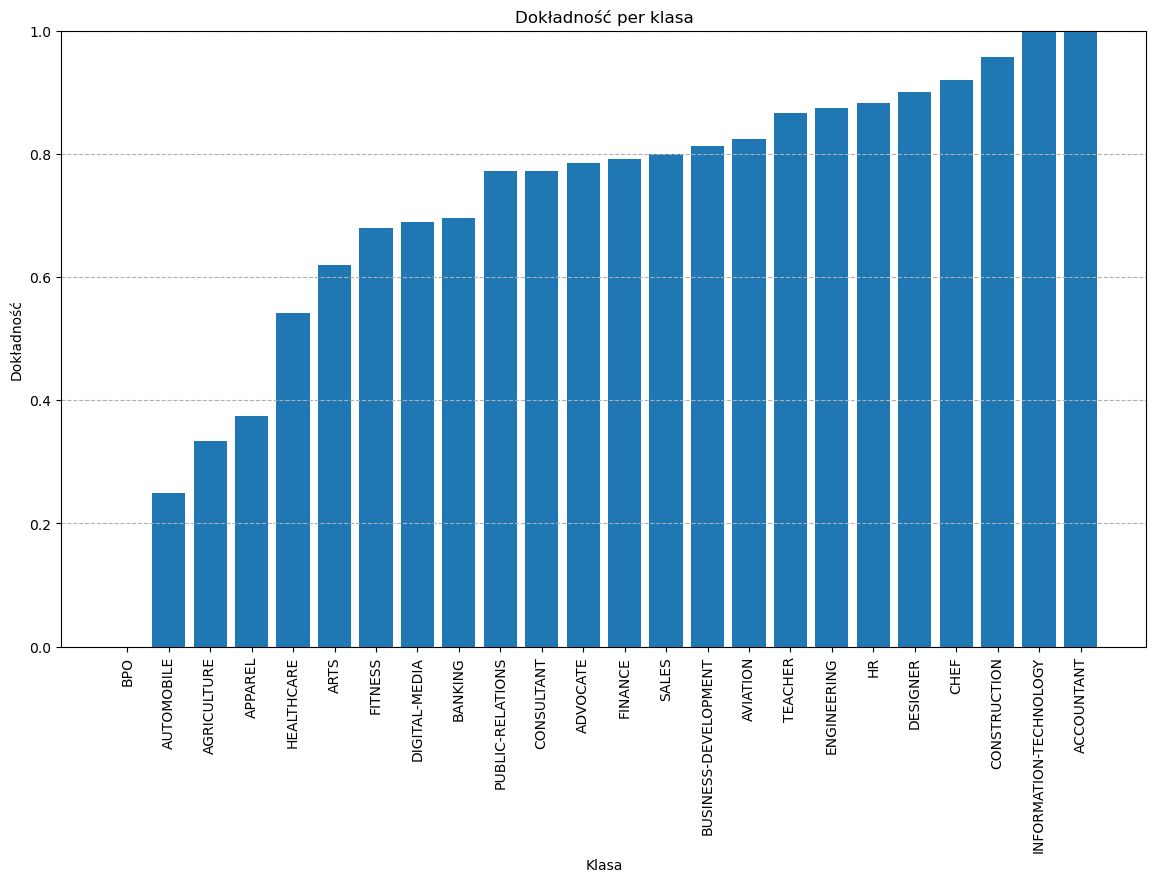

In [185]:
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

classes = label_encoder.classes_

sorted_indices = np.argsort(class_accuracies)
sorted_accuracies = class_accuracies[sorted_indices]
sorted_classes = classes[sorted_indices]

plt.figure(figsize=(14, 8))
plt.bar(sorted_classes, sorted_accuracies)
plt.xlabel('Klasa')
plt.ylabel('Dokładność')
plt.title('Dokładność per klasa')
plt.xticks(rotation=90)
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--')
plt.show()

# Gini and ROC

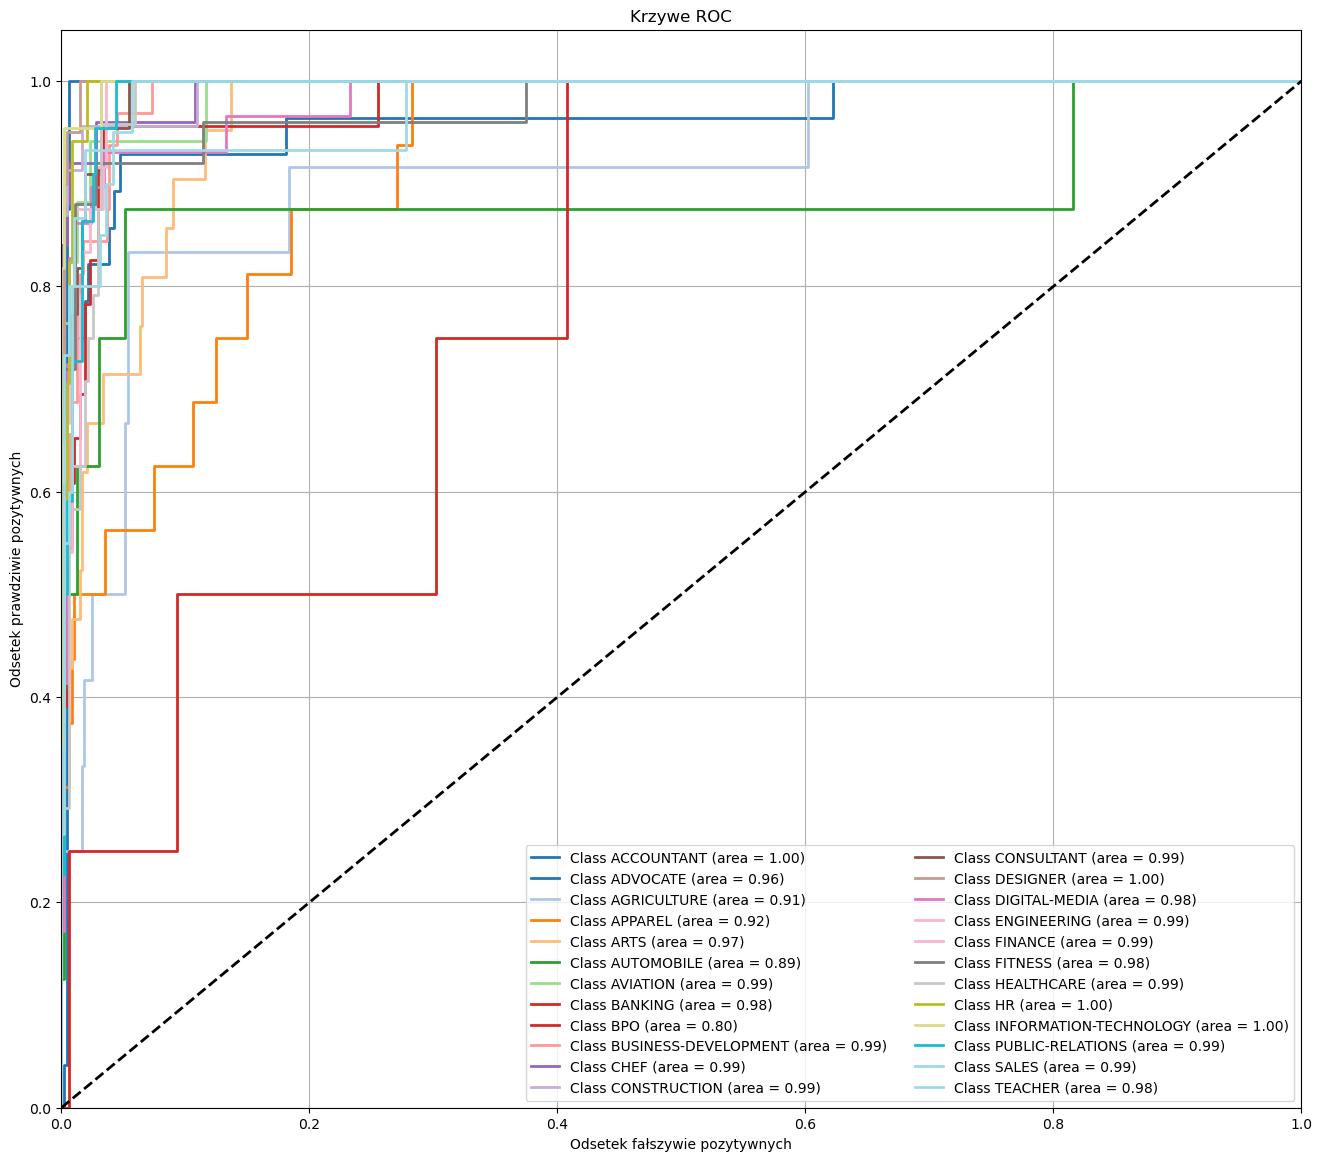

Gini Coefficient: 0.9388078536870494


In [186]:
n_classes = len(label_encoder.classes_)
colors = cm.get_cmap('tab20', n_classes)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(16, 14))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'Class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Krzywe ROC')

plt.legend(loc="lower right", bbox_to_anchor=(1, 0), ncol=2)

plt.grid(True)
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
gini = 2 * roc_auc - 1
print(f'Gini Coefficient: {gini}')